# 1.Problem Statement
  In this project i have to develop stack overflow search engine based on semantic meaning so when user search any question on search engine then it should give relevant and and semantically most similar results.
  In order to understand data i need following:

    1. Title
    2. Question body
    3. Answer of the question
    4. Votes of each answers

# 2. Business Objective
    1. We have to find top n result based in semantic similariy and it should be most relevant to user's requirements.
    2. Top results should be based on both question and answer, that means if user search for any question then in top results it can be most relevant answer or it can be most similar question that other have asked.

# 2. Business Constraints
    1. Low latency Requirement.
    2. Search engine should display Most relevant result.

# 3.Data Collection
1. Google BigQuery dataset includes an archive of stackoverflow contents.it includes posts, votes, tags and badges.This dataset is also available on stack exchange internet archive, here is link : https://archive.org/details/stackexchange
, For more understanding, Data is also availabe on kaggle, link: https://www.kaggle.com/stackoverflow/stackoverflow 

2. i will obtain data by using GoogleBigQuery for that we have to create project on GCP to get project ID and Google Application credentials.

3. Dataset contains many tables but we only use 'post_question' and 'post_answer' tables.
  * post_question contains fields like, question_id, title, body, creation date etc..
  * post_answer has fields like, answer_id, answer body, comment count,creation date etc

4. We will join these 2 tables on id's of question and answer and we will get 
id, title, Question body, question answer and votes for the answer and i will restrict data only for python and sports related question

5. To get data from google cloud dataset we should have google cloud account and have to use google's big query 

6. Using googles's big query we will get the data and store it to drive

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Authenticate google account for acces google public dataset
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [4]:
from google.cloud import bigquery

In [5]:
# project id which we can get from GCP
project_id = 'eminent-facet-283205'

In [6]:
# Google credentials which we can get fromGCP as json file and store it to drive
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="My First Project-79ec2149eeab.json"

In [7]:
client = bigquery.Client()
dataset_reference = client.dataset('stackoverflow', project='bigquery-public-data')
dataset = client.get_dataset(dataset_reference)

In [8]:
# list of tables availbale in stackoverflow dataset
# reference : https://www.kaggle.com/fluffyhamster/stack-overflow-data
tables = list(client.list_tables(dataset))
for table in tables:
    print(table.table_id)

badges
comments
post_history
post_links
posts_answers
posts_moderator_nomination
posts_orphaned_tag_wiki
posts_privilege_wiki
posts_questions
posts_tag_wiki
posts_tag_wiki_excerpt
posts_wiki_placeholder
stackoverflow_posts
tags
users
votes


In [ ]:
# we will only use post question and post question tables for joining.

In [9]:
# The pandas-gbq library is a community led project by the pandas community. 
# It covers basic functionality, such as writing a DataFrame to BigQuery and running a query, 
# but as a third-party library it may not handle all BigQuery features or use cases.
# reference: https://colab.research.google.com/notebooks/bigquery.ipynb#scrollTo=oKNxsRvuKtAz

df = pd.io.gbq.read_gbq('''
  SELECT q.id, q.title, q.body, q.tags, a.body as answers,
  a.score FROM `bigquery-public-data.stackoverflow.posts_questions` AS q 
  INNER JOIN `bigquery-public-data.stackoverflow.posts_answers` AS a 
  ON q.id = a.parent_id 
  LIMIT 1000000
  ''', project_id=project_id, dialect='standard')

In [10]:
df.head()

,id,title,body,tags,answers,score
0,27880607,How to assign an action for UIImageView object...,<p>I'm trying to assign an <code>UIImageView</...,ios|swift|uiimageview,<p>For swift 2.0 and above do this</p>\n\n<pre...,14
1,23482748,How to create a hyperlink with a Label in Tkin...,<p>How do you create a <strong>hyperlink</stro...,python|hyperlink|tkinter|label,"<p>Bind the label to <code>""&lt;Button-1&gt;""<...",34
2,19487576,Gradle build null console object,<p>I'm trying to get my gradle builds to promp...,gradle|android-gradle-plugin|build.gradle,"<p>Ok, the reason why this didn't work was sil...",16
3,25157511,NewtonSoft add JSONIGNORE at runTime,<p>Am looking to Serialize a list using <stron...,c#|attributes|json.net,<p>No need to do the complicated stuff explain...,75
4,1160711,PHP and dealing with foreign characters for UT...,<p>I am currently scraping some data from the ...,php|xml|character-encoding,<p>Don't bother with entity encoding. Use CDAT...,-2


In [11]:
# we have taken 500000 rows 
df.shape

(1000000, 6)

## Data Analysis and EDA

In [ ]:
df = pd.read_csv('/content/drive/My Drive/self_case_study1/data/data1.csv')
df

,id,title,body,tags,answers,score
0,17256604,Python Class __init__ Not Working,<p>This is some really simple code I am using ...,python|class|sqlalchemy,<p>The reason <code>session.query(Game).first...,-2
1,22938679,Error trying to install Postgres for python (p...,<p>I tried to install psycopg2 to my environme...,python|django|heroku|psycopg2,"<p>For <code>Ubuntu 14.04</code>, from Docker ...",33
2,22938679,Error trying to install Postgres for python (p...,<p>I tried to install psycopg2 to my environme...,python|django|heroku|psycopg2,<p>The <code>python-dev</code> package is requ...,153
3,7160737,Python - How to validate a url in python ? (Ma...,<p>I have <code>url</code> from the user and I...,python|url|malformedurlexception,"<p>Actually, I think this is the best way.</p>...",124
4,7160737,Python - How to validate a url in python ? (Ma...,<p>I have <code>url</code> from the user and I...,python|url|malformedurlexception,"<p>A True or False version, based on @DMfll an...",63
...,...,...,...,...,...,...
499995,56198802,Python f-string: replacing newline/linebreak,"<p>First off all, sorry: I'm quite certain thi...",python|python-3.7|f-string,"<ol>\n<li>don't use f-strings, especially for ...",-1
499996,50935665,"Clarifai: ""Malformed or invalid request""",<p>I have the following Python code that makes...,python|clarifai,<p>Needed quotes around the data variable</p>\...,-1
499997,12458198,merging selenium rc and webdriver,<p>I have made most of my automation code usin...,python|webdriver|selenium-rc|selenium-webdrive...,<pre><code>import com.thoughtworks.selenium.De...,-1
499998,39927950,When i try to scrape details page for image I ...,<p>I am trying to get the image of the details...,python|parsing|beautifulsoup|screen-scraping|f...,<p>You need to do something like this:</p>\n\n...,-1


In [13]:
# print dataframe info.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 6 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   id       1000000 non-null  int64 
 1   title    1000000 non-null  object
 2   body     1000000 non-null  object
 3   tags     1000000 non-null  object
 4   answers  1000000 non-null  object
 5   score    1000000 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 45.8+ MB


In [ ]:
# we have no null values in any of the columns

In [14]:
# checking for null values
df.isna().sum()

id         0
title      0
body       0
tags       0
answers    0
score      0
dtype: int64

In [15]:
# checking for duplicate values
df.duplicated().any()

False

In [16]:
# checking for duplicate values
print(df.duplicated('id').any())
print(df.duplicated('title').any())
print(df.duplicated('body').any())
print(df.duplicated('tags').any())
print(df.duplicated('answers').any())

True
True
True
True
True


## Data aggregation
    1. As we can se here are some duplicate rows in dataframe.
    2. so i will concatnate  answers based on duplicate id.
    3. i will sum up score also based on duplicate id.

In [17]:
# create corpus
# combine answers and take sum of votes with duplicate id,questions,title and tags 
aggregated = {'answers': lambda x: "\n".join(x), 'score': 'sum'}
# aggregate df
grouped = df.groupby(['id','title', 'body','tags'],as_index=False).agg(aggregated)
# make dataframe
final_deduplicate_df = pd.DataFrame(grouped)

In [18]:
# Look at shape after aggregation 
final_deduplicate_df.shape

(572554, 6)

In [19]:
print('Total duplicate rows we have removed is = ',(df.shape[0]-final_deduplicate_df.shape[0]))

Total duplicate rows we have removed is =  427446


In [20]:
# maximum score before and after aggregation so we can see effect of aggregation
print('Max score of votes before aggregation',np.max(df.score.values))
print('Max score of votes after aggregation',np.max(final_deduplicate_df.score.values))

Max score of votes before aggregation 11021
Max score of votes after aggregation 14645


In [21]:
print('Columns of Dataset',final_deduplicate_df.columns)

Columns of Dataset Index(['id', 'title', 'body', 'tags', 'answers', 'score'], dtype='object')


In [22]:
print('Number of rows in dataframe',final_deduplicate_df.shape[0])

Number of rows in dataframe 572554


# Analysis on Tags

In [23]:
final_deduplicate_df['tag_count'] = final_deduplicate_df['tags'].apply(lambda x : len(x.split('|')))
# apply function will make change in values of series

In [24]:
final_deduplicate_df[['tags','tag_count']]

,tags,tag_count
0,c#|.net|datetime,3
1,c#|datetime|time|datediff|relative-time-span,5
2,java|php|oop|theory,4
3,c++|oop|class|nested-class,4
4,python|django|views|oop,4
...,...,...
572549,c#|backend|dto,3
572550,c++,1
572551,postgresql|indexing|partial-index,3
572552,python|python-3.x|string|replace,4


In [28]:
# this is the directory where we will put our data
currentDirectory = "/content/drive/My Drive/self_case_study1/"
# this is for data directory where we will store data.csv
dataDirectory = currentDirectory + "data/"
# store dataframe as csv to working the directory
final_deduplicate_df.to_csv(dataDirectory + 'all_data.csv',encoding='utf-8',index=False)

In [25]:
# maximum tags in question
print('Maximum number of tag in any question is =',np.max(final_deduplicate_df['tag_count']))
# minimum tags in question
print('Mimimum number of tag in any question is =',np.min(final_deduplicate_df['tag_count']))

Maximum number of tag in any question is = 6
Mimimum number of tag in any question is = 1


In [29]:
import seaborn as sns

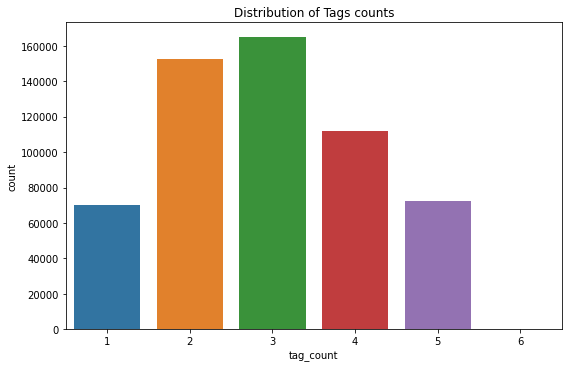

In [30]:
# define figure size
fig = plt.figure(figsize=(8,5))
# countplot usinf seaborn
sns.countplot(x='tag_count',data=final_deduplicate_df)
# for better visulization use tight layout
plt.tight_layout()
# title of the plot
plt.title('Distribution of Tags counts')
# showing plot
plt.show()

### Observation:
 1. By watching above plot we can observe that most of the questions have 3 or 2 tags, and very small amount of questions have only 1 tag in it.
 2.Question with 1 and 5 tags are almost same.
 3. Maximum number of tag in any question is 5.
 4. Minimum number of tag in any question is 1.

#### Analysis on unique tags and Most frequent tag

In [31]:
# import CountVectorizer from sklearn
from sklearn.feature_extraction.text import CountVectorizer
# instantiate object to do count of tags
CV = CountVectorizer(tokenizer = lambda x : x.split('|'))
# Bag of words for tags with frequencies of each tag
tag_bag_words = CV.fit_transform(final_deduplicate_df['tags'])

In [32]:
tag_bag_words.shape

(572554, 35571)

In [33]:
print('Total Number of Unique Tags',tag_bag_words.shape[1])

Total Number of Unique Tags 35571


In [34]:
# taking sum of each tags
# below line will sum the each column of sparce matrix and A1 converts matrix into array
tag_column_sum = tag_bag_words.sum(axis=0).A1
# make dictionary of each unique tag frequency count
tag_freq_count = dict(zip(CV.get_feature_names(),tag_column_sum))
# sort above dict in Descending order of tag count
tag_freq_count_sorted = dict(sorted(tag_freq_count.items(), key = lambda x: x[1], reverse = True))

In [35]:
# top 10 most frequent tags
list(tag_freq_count_sorted.items())[:10]

[('javascript', 57610),
 ('java', 47535),
 ('python', 40462),
 ('c#', 40064),
 ('php', 39090),
 ('android', 36325),
 ('jquery', 30018),
 ('html', 29473),
 ('css', 20017),
 ('c++', 18425)]

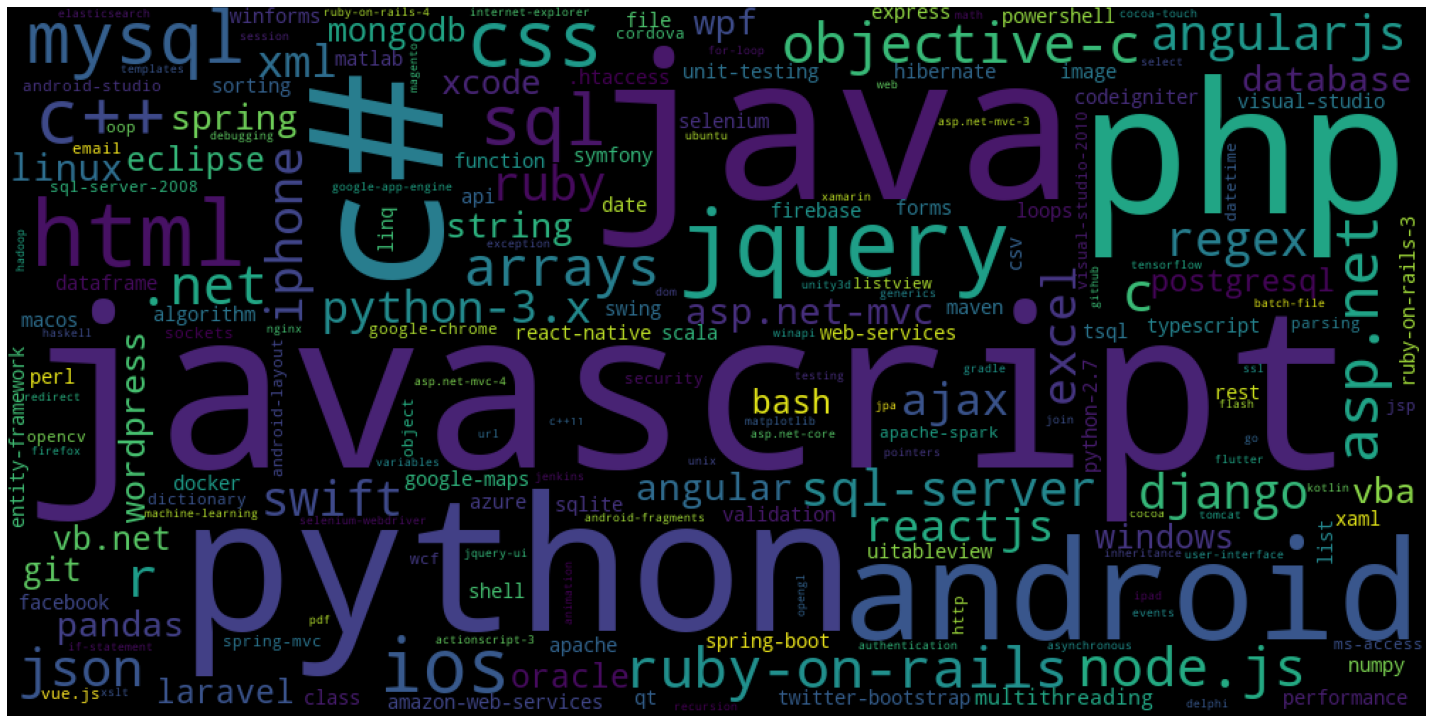

In [38]:
# generate wordcloud from frequencies of tag counts
# Reference : https://stackoverflow.com/questions/16645799/how-to-create-a-word-cloud-from-a-corpus-in-python
from wordcloud import WordCloud
Wcloud = WordCloud(width=1000,height=500)
Wcloud.generate_from_frequencies(tag_freq_count)
plt.figure(figsize=(20,20))
plt.imshow(Wcloud)
plt.axis('off')
plt.tight_layout()
plt.show()

#### Observation
 1. From above word cloud we can observ that size of Python word is very big that means **javascript** is most frequent word.
 2. Java is second most frequent word and python and c# is 3rd and 4th most frequent words.


#### Bar Plot of Top 10 tags vs frquency

In [43]:
tags = list(tag_freq_count_sorted.keys())[:15]
freq = list(tag_freq_count_sorted.values())[:15]

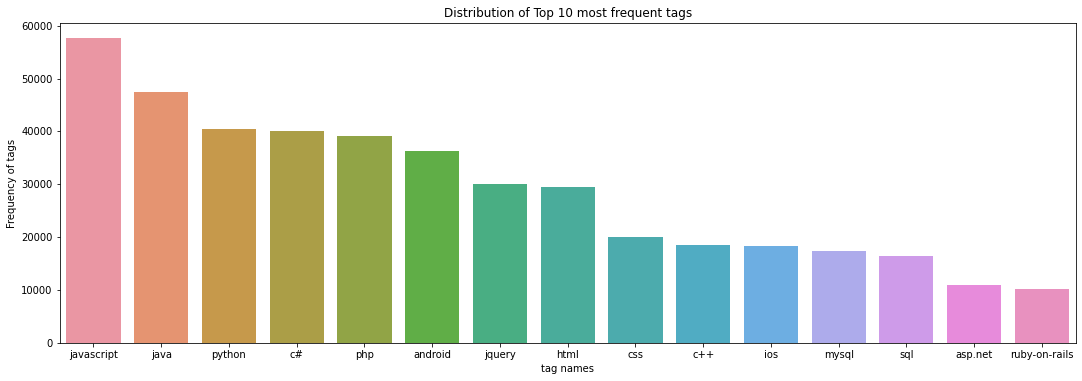

In [46]:
# define figure size
fig = plt.figure(figsize=(15,5))
# Barplot using seaborn
sns.barplot(x=tags,y=freq)
# for better visulization use tight layout
plt.tight_layout()
# title of the plot
plt.title('Distribution of Top 10 most frequent tags')
plt.xlabel('tag names')
plt.ylabel('Frequency of tags')
# showing plot
plt.show()

###Observation
* Most frequent tags are javascript and java and python


#### Plot for frequency distribution

Text(11.625, 0.5, 'frequency')

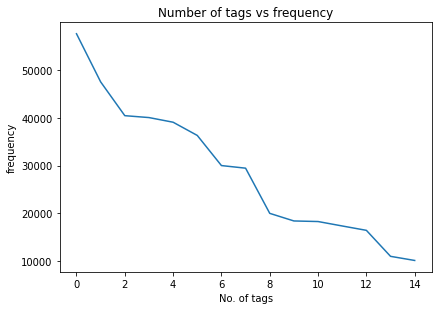

In [47]:
plt.plot(freq)
plt.tight_layout()
plt.title('Number of tags vs frequency')
plt.xlabel('No. of tags')
plt.ylabel('frequency')

#### Obseravtion
* From above plot we can observe that there are very few tags whose frequency is very high, Actually we have seen that in bar plot that only javascript tag is most frequent.
* Except javascript tag all other tags frequenct is below 50000.
* Two tags(python and c#) have frequency is around 40,000.

### countplot for Voting Score

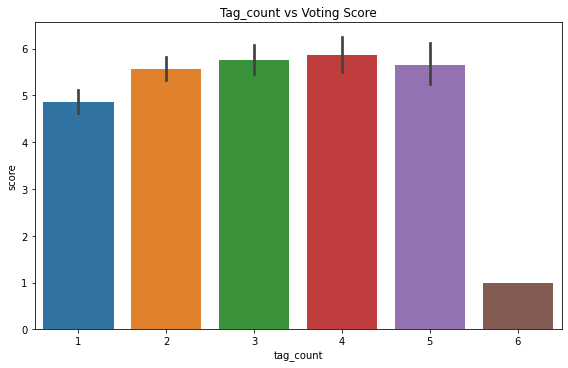

In [48]:
# define figure size
fig = plt.figure(figsize=(8,5))
# Barplot using seaborn
sns.barplot(x=final_deduplicate_df['tag_count'],y=final_deduplicate_df['score'])
# for better visulization use tight layout
plt.tight_layout()
# title of the plot
plt.title('Tag_count vs Voting Score')
# showing plot
plt.show()

#### Obseravtion
* From above plot we observes that question with  6 tag count has very low voting score.
* Questions with tag count 4 has highest rating amontgst all
* Questions with 2,3 and 5 tag counts have almost same voting score.